# **Этап 3.1: Построение моделей: Random Forest**

# **Шаг 1: Подготовка инструментов**

**1.1 Необходимые модули и функции**

In [1]:
from google.colab import files
import io
from sklearn.pipeline import Pipeline
import pandas as pd
import dill
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold


%matplotlib inline

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))


**1.2 Загрузка пайплайна препроцессинга**


In [4]:
uploaded = files.upload()
with open('/content/prep_with_cat.dill', 'rb') as prep_cat_pipeline:
    prep_cat = dill.load(prep_cat_pipeline)
    

Saving prep_with_cat.dill to prep_with_cat.dill


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator ColumnTransformer from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use

**1.3 Загрузка данных**

In [5]:
uploaded = files.upload()
train_base = pd.read_csv(io.BytesIO(uploaded['X_train.csv']))
uploaded = files.upload()
train_target_base = pd.read_csv(io.BytesIO(uploaded['y_train.csv']))
uploaded = files.upload()
test_base = pd.read_csv(io.BytesIO(uploaded['X_test.csv']))
uploaded = files.upload()
test_target_base = pd.read_csv(io.BytesIO(uploaded['y_test.csv']))

Saving X_train.csv to X_train.csv


Saving y_train.csv to y_train.csv


Saving X_test.csv to X_test.csv


Saving y_test.csv to y_test.csv


In [16]:
train = train_base.copy()
train_target = train_target_base.copy()
display(train.shape, train_target.shape)

(641, 11)

(641, 1)

In [17]:
test = test_base.copy()
test_target = test_target_base.copy()
display(test.shape, test_target.shape)

(276, 11)

(276, 1)

# **Шаг 2: Построение модели**

**2.1 Baseline**

Обучим модель с параметрами по умолчанию на тренировочной выборке.

In [18]:
classifier = Pipeline([
    ('preprocessing', prep_cat),
    ('classifier', RandomForestClassifier(random_state = 0)),
])

classifier.fit(train, train_target)

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('preprocessor',
                                  ColumnTransformer(n_jobs=None,
                                                    remainder='drop',
                                                    sparse_threshold=0.3,
                                                    transformer_weights=None,
                                                    transformers=[('num',
                                                                   Pipeline(memory=None,
                                                                            steps=[('minmax',
                                                                                    MinMaxScaler(copy=True,
                                                                                                 feature_range=(0,
                                                                                        

In [19]:
train_pred_proba = classifier.predict_proba(train)
train_pred = classifier.predict(train)
test_pred_proba = classifier.predict_proba(test)
test_pred = classifier.predict(test)
print(f'Train ROC_AUC: {roc_auc_score(train_target, train_pred_proba.T[1])}')
print(f'Train F1 SCORE: {f1_score(train_target, train_pred)}')
print(f'Test ROC_AUC: {roc_auc_score(test_target, test_pred_proba.T[1])}')
print(f'Test F1 SCORE: {f1_score(test_target, test_pred)}')

Train ROC_AUC: 1.0
Train F1 SCORE: 1.0
Test ROC_AUC: 0.9565332908231043
Test F1 SCORE: 0.906040268456376


In [20]:
get_classification_report(train_target['HeartDisease'], train_pred, test_target['HeartDisease'], test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       287
           1       1.00      1.00      1.00       354

    accuracy                           1.00       641
   macro avg       1.00      1.00      1.00       641
weighted avg       1.00      1.00      1.00       641

TEST

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       123
           1       0.93      0.88      0.91       153

    accuracy                           0.90       276
   macro avg       0.90      0.90      0.90       276
weighted avg       0.90      0.90      0.90       276



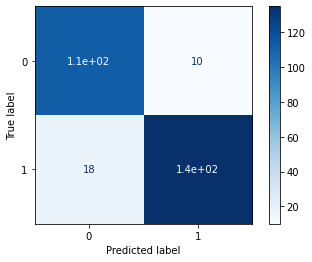

In [21]:
plot_confusion_matrix(classifier, test, test_target['HeartDisease'], cmap=plt.cm.Blues);

**2.2 Подбор гиперпараметров**

Гиперпараметры подбираем с помощью GridSearchCV с кроссвалидацией на 5 фолдов.

In [22]:
%%time
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

frozen_params = {
    'random_state': 0
}
parameters = {
    'criterion': ['gini', 'entropy'], 
    'n_estimators': [10, 100, 500, 1000, 1500], 
    'max_depth' : [None, 5, 10, 20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15]
}

clf = GridSearchCV(RandomForestClassifier(**frozen_params), parameters, n_jobs=-1, verbose=3, scoring='f1' ,cv=cv)

classifier = Pipeline([
    ('preprocessing', prep_cat),
    ('classifier', clf),
])
classifier.fit(train, train_target)

Fitting 5 folds for each of 3000 candidates, totalling 15000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 2044 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 36.3min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 44.7min
[Parallel(n_jobs=-1)]: Done 3868 tasks      | elapsed: 53.9min
[Parallel(n_jobs=-1)]: Done 4604 tasks      | elapsed: 64.3min
[Parallel(n_jobs=-1)]: Done 5404 tasks      | elapsed: 75.6min
[Parallel(n_jobs=-1)]: Done 6268 tasks      | elapsed: 87.7min
[Parallel(n_jobs=-1)]: Done 7196 tasks      | e

CPU times: user 2min 6s, sys: 9 s, total: 2min 15s
Wall time: 3h 35min 31s


**2.3 Итоговая модель**

Обучим модель с лучшими параметрами на тренировочной выборке и посмотрим итоговое качество на тестовой выборке.

In [23]:
print(clf.best_score_)
print(clf.best_params_)

0.8796937018300005
{'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [25]:
classifier = Pipeline([
    ('preprocessing', prep_cat),
    ('classifier', RandomForestClassifier(**clf.best_params_, random_state = 0)),
])
classifier.fit(train, train_target)

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('preprocessor',
                                  ColumnTransformer(n_jobs=None,
                                                    remainder='drop',
                                                    sparse_threshold=0.3,
                                                    transformer_weights=None,
                                                    transformers=[('num',
                                                                   Pipeline(memory=None,
                                                                            steps=[('minmax',
                                                                                    MinMaxScaler(copy=True,
                                                                                                 feature_range=(0,
                                                                                        

In [26]:
train_pred_proba = classifier.predict_proba(train)
train_pred = classifier.predict(train)
test_pred_proba = classifier.predict_proba(test)
test_pred = classifier.predict(test)

In [27]:
get_classification_report(train_target['HeartDisease'], train_pred, test_target['HeartDisease'], test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       287
           1       0.91      0.95      0.93       354

    accuracy                           0.93       641
   macro avg       0.93      0.92      0.92       641
weighted avg       0.93      0.93      0.92       641

TEST

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       123
           1       0.91      0.88      0.89       153

    accuracy                           0.88       276
   macro avg       0.88      0.89      0.88       276
weighted avg       0.89      0.88      0.88       276



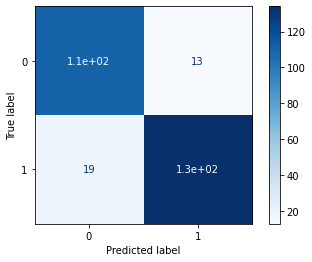

In [28]:
plot_confusion_matrix(classifier, test, test_target['HeartDisease'], cmap=plt.cm.Blues)


In [30]:
# **Шаг 3: Сохранение обученной модели**
with open("model_RandomForestClassifier.dill", "wb") as f:
    dill.dump(classifier, f)